## Тестирование
Для обучения использовались первые 210 вольюмов, для тестирования — последние 60. 

Все обученные модели сравниваются со средним фМРТ на тренировочной выборке (то есть сравнивается с константой).
Для сравнения используется следующая статистика:
$$Q_i = \sqrt{\frac{\sum_t(y_i^t - p_i^t) ^ 2}{\sum_t(y_i^t - m_i^t) ^ 2}}$$
$y_i^t$ - значение фМРТ вокселя i во времени t, 

$m_i^t$ - значение средненго по обучению фМРТ вокселя i во времени t, 

$p_i^t$ - значение предсказания фМРТ вокселя i во времени t

Если $Q_i < 1$, то модель работает лучше среднего предсказания, иначе хуже.

Ниже подсчет статистик для обученных моделей и картинки для лучшей (по медианной метрике) модели

In [1]:
import os
import pickle
import multiprocessing
import itertools
import numpy as np
from tqdm import tqdm_notebook

from skimage import io
from matplotlib import pyplot as plt
from skimage.morphology import erosion, square
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet

from IPython.display import clear_output
from dataHandlers.datasetCreator import Sampler
from dataHandlers import settings
from visualisation.utils import concatenate_collage


In [3]:
sampler = Sampler('../data', segment_length=1024*4)
clear_output()

In [4]:
num_frames = 300
num_train_frames = 210
num_val_frames = 30
num_test_frames = 60
train_start = 0
train_end = settings.frame_creation_time * num_train_frames
test_start = settings.frame_creation_time * (num_frames - num_test_frames)
test_end = settings.frame_creation_time * num_frames

patient_list = sampler.patient_list
random_state = 42

save_path = '../experiments/linear/elastic_2'
models_path = os.path.join(save_path, 'models')
pcas_path = os.path.join(save_path, 'pcas')


In [5]:
def get_fmri_slice_mask(mean_fmri_slice):
    non_empty_voxels = mean_fmri_slice > 66
    voxels_num = non_empty_voxels.sum()
    selem_size = int(np.sqrt(voxels_num) / 4.5)
    entire_voxels = erosion(mean_fmri_slice > 66, selem=square(selem_size))
    result_mask = non_empty_voxels * ~entire_voxels
    return result_mask

def get_fmri_mask(fmri):
    mean_fmri = fmri.mean(-1)
    fmri_mask = np.concatenate([get_fmri_slice_mask(mean_fmri[..., i])[..., None] for i in range(30)], -1)
    return fmri_mask

In [6]:
current_patient = patient_list[0]
fmri = sampler.fmri_data[current_patient]
mean_fmri = fmri.mean(-1)
tresholded_mask = mean_fmri > 66
fmri_mask = get_fmri_mask(fmri)

In [7]:
def get_masked_y(y, fmri_mask):
    return y[np.concatenate([fmri_mask[None, ...]] * y.shape[0])].reshape(y.shape[0], -1)

In [8]:
x_train, y_train = sampler.create_one_man_dataset(current_patient, train_start, train_end)
x_test, y_test = sampler.create_one_man_dataset(current_patient, test_start, test_end)

preprocessed_train_y = get_masked_y(y_train, fmri_mask)
preprocessed_test_y = get_masked_y(y_test, fmri_mask)

mean_train_y = preprocessed_train_y.mean(0)

mean_score = (preprocessed_test_y - mean_train_y[None, ...]) ** 2

In [9]:
pcas_paths_list = [os.path.join(pcas_path, pca_name) for pca_name in os.listdir(pcas_path)]
models_paths_list = [os.path.join(models_path, model_name) for model_name in os.listdir(models_path)]

In [10]:
model_score_dict = {}
prediction_dict = {}

for pca_path in pcas_paths_list:
    pca_name = pca_path.split('/')[-1]
    patient_name, pca_num_features = pca_name[:-4].split('_')
    if patient_name != current_patient:
        continue
        
    pca = pickle.load(open(pca_path, 'rb'))
    preprocessed_test_x = pca.transform(x_test)
    
    for model_path in models_paths_list:
        model_name = model_path.split('/')[-1]
        current_patient, num_features, alpha, l1_ratio, normalize = model_name[:-4].split('_')
        if patient_name != current_patient or pca_num_features != num_features:
            continue
        model = pickle.load(open(model_path, 'rb'))
        predicted_test_y = model.predict(preprocessed_test_x)
        
        prediction_score = (predicted_test_y - preprocessed_test_y) ** 2 
        voxel_score = np.sqrt(np.sum(prediction_score, 0) / np.sum(mean_score,  0))
        model_score_dict[model_name] = voxel_score
        prediction_dict[model_name] = predicted_test_y

In [11]:
print('{:30}  {:<12}  {:<12}  {:<12}  {:<12}'.format('model name', 'best metric', 'worst metric','mean metric', 'median metric'))
for model in model_score_dict:
    string_format = '{:30}  {:<12.5}  {:<12.5}  {:<12.5}  {:<12.5}'
    print(string_format.format(model,
                               model_score_dict[model].min(),
                               model_score_dict[model].max(),
                               model_score_dict[model].mean(),
                               np.median(model_score_dict[model])))

model name                      best metric   worst metric  mean metric   median metric
49_700_0.55_0.5_True.pkl        1.0           1.0           1.0           1.0         
49_700_0.55_0.0_True.pkl        0.99883       1.001         0.99984       0.99982     
49_700_0.1_0.5_True.pkl         1.0           1.0           1.0           1.0         
49_700_0.55_1.0_False.pkl       0.41103       1.2958        0.99145       1.0         
49_700_0.55_0.5_False.pkl       0.31529       1.8112        0.9647        1.0         
49_700_0.1_1.0_False.pkl        0.19338       4.1555        0.87431       0.97544     
49_700_0.1_0.0_False.pkl        0.074197      6.5724        0.85927       0.7359      
49_700_0.55_1.0_True.pkl        1.0           1.0           1.0           1.0         
49_700_0.1_1.0_True.pkl         1.0           1.0           1.0           1.0         
49_700_0.1_0.0_True.pkl         0.99358       1.0056        0.99913       0.99903     
49_700_0.55_0.0_False.pkl       0.07413   

49_400_1.0_1.0_False.pkl        0.71896       1.0           0.99896       1.0         
49_400_0.1_0.0_True.pkl         0.99348       1.0053        0.99915       0.99904     
49_400_0.1_1.0_False.pkl        0.19338       4.1555        0.87431       0.97544     
49_400_1.0_0.5_False.pkl        0.38867       1.3642        0.98907       1.0         


In [12]:
model_list = list(model_score_dict.keys())
best_model = model_list[np.argmin([np.median(model_score_dict[model]) for model in model_score_dict])]
best_scores = model_score_dict[best_model]

In [13]:
def plot_scores(scores):
    scores_tensor = np.zeros(list(fmri_mask.shape) + [3], dtype=np.float32)
    good_color = np.array([[0, 1, 0]])
    bad_color = np.array([[1, 0, 0]])
    
    scores[scores > 2] = 2
    min_value = scores.min()
    max_value = scores.max()
    
    scaled_scores = (scores - min_value) / (max_value - min_value)
    scaled_scores = scaled_scores[..., None]

    scores_tensor[fmri_mask] = scaled_scores * bad_color + (1 - scaled_scores) * good_color
    collage = concatenate_collage(scores_tensor)
    plt.figure(figsize=[20, 20])
    plt.imshow(collage)
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    #plt.show()
    
    colorbar_points = np.linspace(0, 1, 100, True)[..., None]
    colorbar = colorbar_points * bad_color + (1 - colorbar_points) * good_color
    colorbar = np.concatenate([colorbar[None, ...]]*3, 0)
    plt.figure(figsize=[20, 20])
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    #plt.xticks(colorbar_points[::50], fontsize=20)
    plt.gca().set_xticks(np.arange(0, 110, 11));
    labels = np.linspace(min_value, max_value, 10).astype(np.float16)
    plt.gca().set_xticklabels(labels);
    plt.imshow(colorbar)

Тут нарисованы метрики для каждого вокселя. Черный цвет означает что вокселя не было в обучении, зеленый — он хорошо обучился, красный — плохо

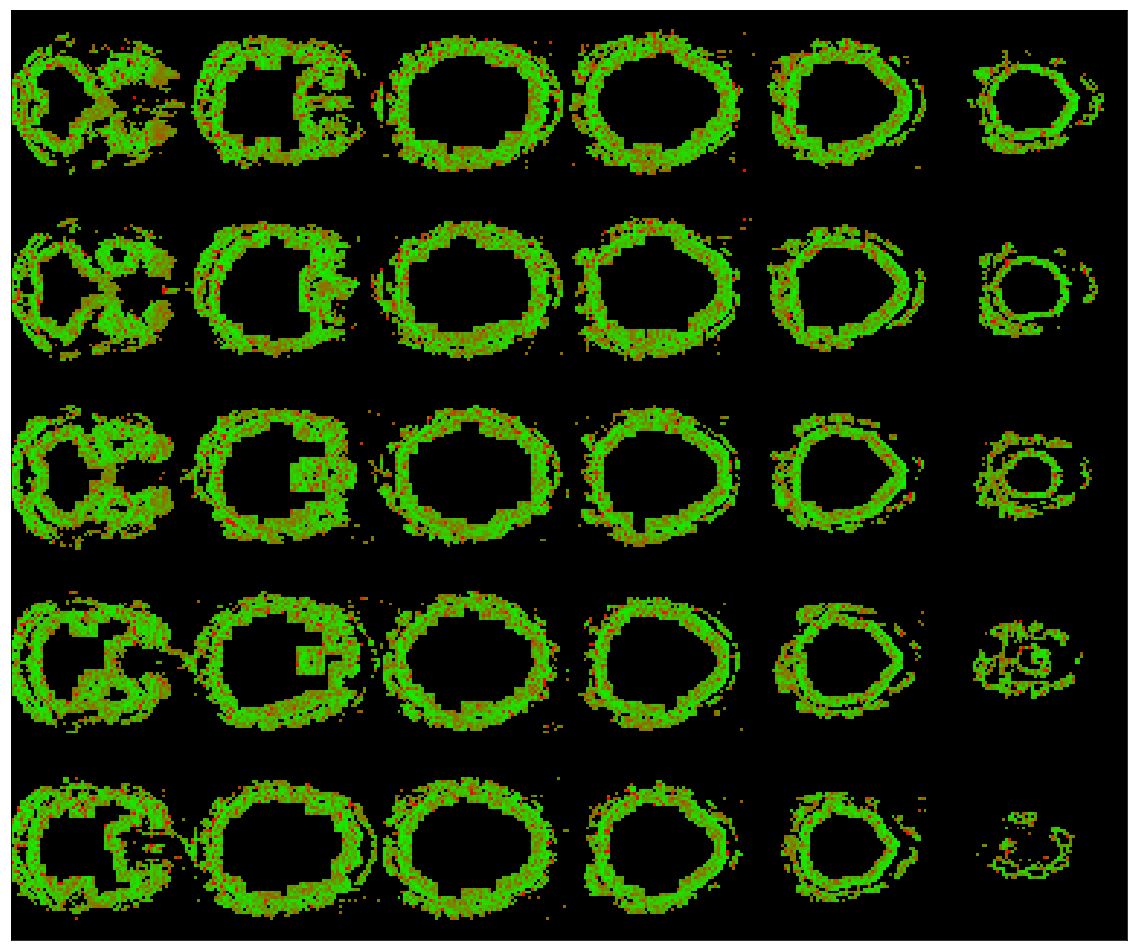

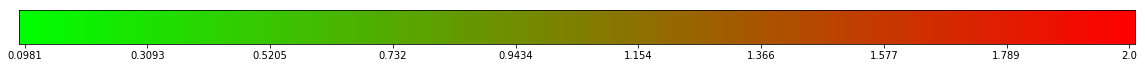

In [14]:
plot_scores(best_scores)

In [15]:
best_voxels = np.argsort(best_scores)[:10]
worst_voxels = np.argsort(best_scores)[-10:]

##### Тут нарисованны предсказания для 10 лучших вокселей

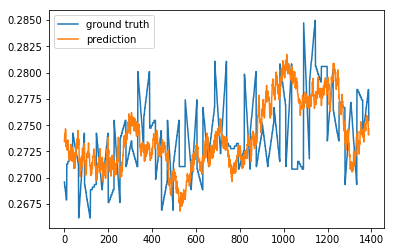

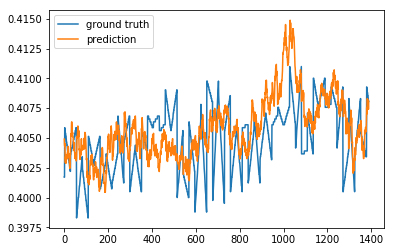

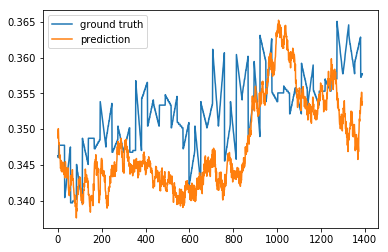

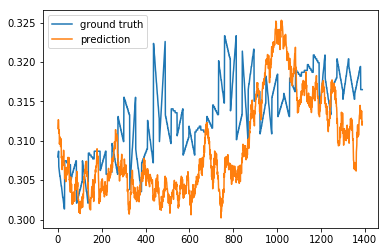

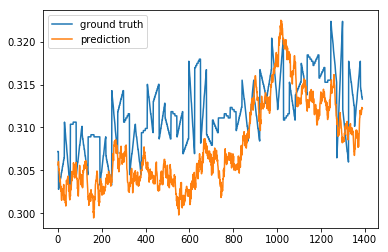

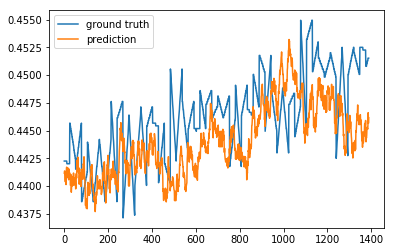

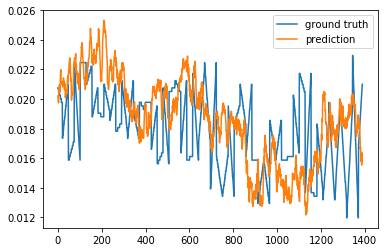

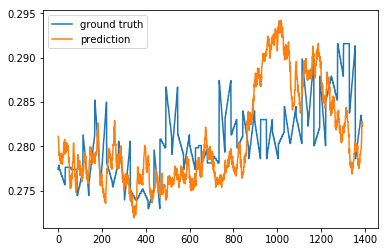

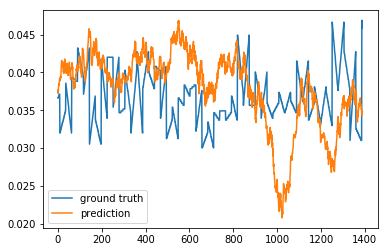

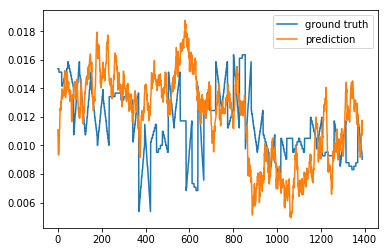

In [16]:
for voxel in best_voxels:
    plt.plot(preprocessed_test_y[..., voxel], label='ground truth')
    plt.plot(prediction_dict[best_model][..., voxel], label='prediction')
    plt.legend()
    plt.show()

##### Тут  предсказания для 10 худших

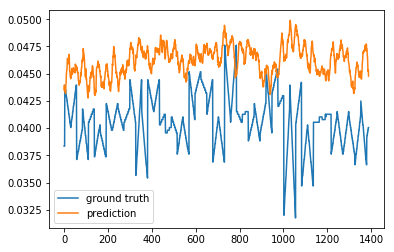

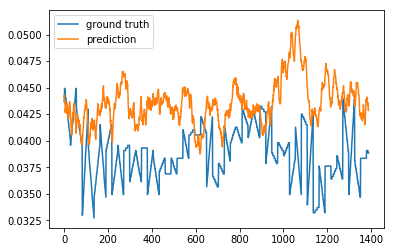

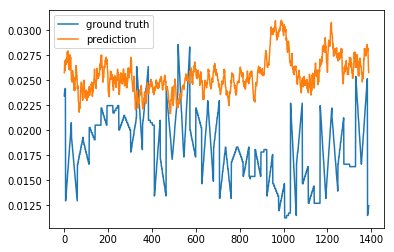

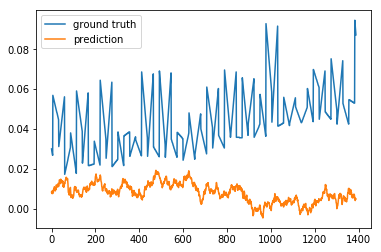

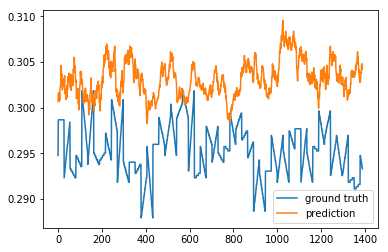

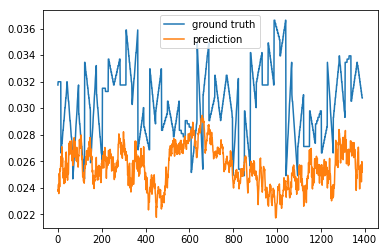

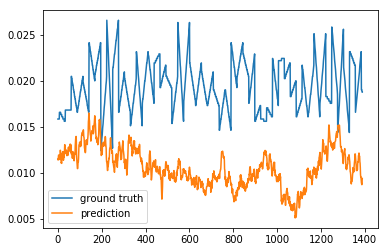

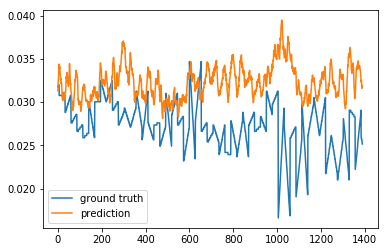

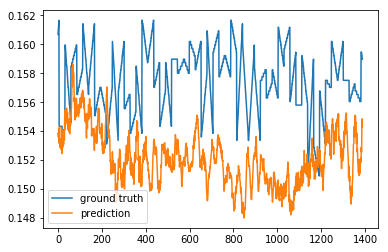

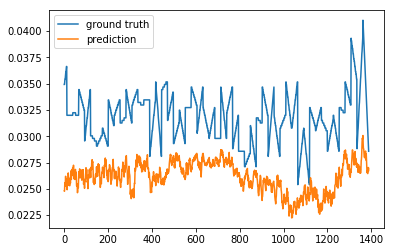

In [17]:
for voxel in worst_voxels:
    plt.plot(preprocessed_test_y[..., voxel], label='ground truth')
    plt.plot(prediction_dict[best_model][..., voxel], label='prediction')
    plt.legend()
    plt.show()